# Dragalia Lost Summoning Strategy Calculator
The purpose of this notebook is to determine the optimal strategy for summoning in the mobile game [Dragalia Lost](https://dragalialost.com/en/). Dragalia Lost allows the user to summon 'units' with which they can play the game. Different units have different rarities, falling into the categories of either 3-stars, 4-stars, or 5-stars, where the rarity increases the more stars the unit has. The intent of this calculator is to find the best strategy for getting the most 5-star units.

## Summoning Rules
The rules of summoning are as follows:
1. There are two types of summons: a single summon and a tenfold summon. A single summon is exactly as it sounds: it summons one unit. A tenfold summon, however, is not only ten summons, but it also guarantees that out of the 10 summons, at least one will be a 4-star unit or higher.
2. A tenfold summon costs 10 times the cost of a single summon.
3. Every 10 summons that go without a 5-star unit appearing causes the chance of a 5-star unit appearing to increase (pity increase). After the completion of a tenfold summon or a single summon, if a 5-star unit was obtained, the pity increase disappears and the chance of a 5-star unit appearing becomes its base rate again.
4. A tenfold summon will only adjust the pity increase after all 10 summons have happened. For an example of where this point is relevant, consider the case where the first summon of the tenfold is a 5-star unit: the remaining 9 summonable units still have the same pity increase (pity increase won't be adjusted until the summon is completed) which could mean better chances, but on the other hand, if none of the remaining summoned units end up being 5-star units, they don't end up counting towards the next pity increase because there was still a 5-star unit in the entire tenfold summon.

## Optimal Strategy Definition
I define an optimal strategy to be the best combination of single and tenfold summons that nets the highest amount of 5-star units given a finite amount of value to spend on summons. There are many conflicting theories about the best strategy to get the most amount of 5-star units for a fixed price: one strategy I found online was to do 10 single summons to raise the pity for a following tenfold, whereas another strategy I found was to do 20 single summons before a tenfold. I will try and explore strategies to determine the best one for getting the most 5-star units with a fixed price.

## Notation
The base rate for summoning 5-star units is actually variable depending on the time of summoning (There is a 4% chance normally, but a 6% chance during 'galas'). As such, I will denote the base rate of summoning as $p$. The pity increase is always in increments of 0.5%, but I will still notate a single pity increase as $q$.<br/><br/>
For an example, supposing I summoned 20 single summons without getting a 5-star unit. The rate at which I would get 5-star units for my next summon would be $p + 2q$ which is the base rate plus 2 pity increases. If I then proceeded to perform either type of summon and get at least one 5-star unit, the rate at which I would get 5-star units would then become $p$ for the next summon because the pity has been broken.<br/><br/>
Throughout this notebook, I refer to a strategy number. I encode strategies as a number between 0 and 12 where the number represents how many sets of 10 single summons to perform before using entirely tenfold summons. The assumptions that justify such a narrow and simplistic view of strategies are listed below.

In [1]:
# List of strategies: strategies are encoded as how many sets of 10 single summons to perform before pity-breaking with tenfolds
# eg. the strategy that is encoded as 2 means perform 20 single summons and then do tenfolds until a 5-star unit is obtained
# Strategies go from 0 (entirely tenfolds) to 12 (entirely single summons) because of the assumption of 120 total summons
strategies = range(13)

## Problem Statement / Assumptions
I will define a strategy as a sequence of single summons and tenfold summons that is repeated until the desired number of summons has been performed. How this works is described in further detail below.<br/><br/>
For the sake of this problem, I will assume that I have enough Wyrmite (currency) to perform 120 summons total (this ends up being 14,400 Wyrmite). I chose 120 because 12 is divisible in many ways and 10 summons is the base unit for the pity increase and for the tenfold summon. Furthermore, 120 is a typical number of summons that I tend to perform at a time. The optimal strategy for 120 may scale up and probably still performs well when scaled up, but it isn't guaranteed to be the optimal strategy for larger numbers of summons because there may be other strategies that will not be tested with the assumption of 120 summons.<br/><br/>
In a similar vein, I will also assume that I am summoning during a Gala (with a base 5-star rate of 6%). I typically only summon during Galas and that is the best way to get 5-stars because it has the highest base rate.<br/><br/>
Another important assumption is that single summons will only ever be done in groups of 10. I am making this assumption because if single summons are not done in groups of 10, they are not being used optimally for the pity increase. For example, if I were to perform 5 single summons and then a tenfold summon, the single summons have no bearing on the pity increase: either the tenfold netted a 5-star unit and the pity increase is reset, or the tenfold summon gave no 5-star units and the pity rate was raised once. The 5 single summons in that scenario contributed nothing.<br/><br/>
I will also assume that the optimal strategy restarts as soon as a 5-star unit has been obtained. For example, if a strategy is to perform 30 single summons and then a tenfold summon, but a 5-star unit is obtained on the 3rd summon, rather than continuing with 27 single summons and then a tenfold summon, I will assume that it is optimal to restart the strategy from the beginning. My justifications for this assumptions are partially derived from the previous assumption.<br/><br/>
Furthermore, I will assume that the optimal strategy, if it involves single summons, will have the single summons always before tenfold summons. I am assuming this because tenfold summons are ideal with a high pity increase and single summons are optimal for raising pity. It doesn't make sense for a single summon to occur after a tenfold because the higher pity would be wasted with a single summon only being able to give at most 1 5-star unit. Along a similar vein, this means that I will assume the optimal strategy will always involve trying to finish the summon off with tenfold summons until the pity has been broken: it doesn't make sense to restart the strategy to single summons if the previous run-through of the strategy raised the pity and didn't net a 5-star unit.<br/><br/>
Lastly, I will assume that the guaranteed 4-star or above unit in a tenfold summon has no bearing on the probability of getting a 5-star unit. I am unsure of whether this is a fair assumption, but I am unable to find any information on how this guarantee is resolved.

In [2]:
# For the sake of this problem, 120 summons will be assumed
numberSummons = 120

# I will use a 6% base 5-star rate because I mainly only summon during galas which have this rate
# The base rate can also be changed to 0.04 (4%) which is the normal base rate of 5-star summons
# Pity rate is always 0.5%
p = 0.06
q = 0.005

## Mathematical Description
The tenfold summons can be considered to follow a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) because each of the summons is either a 5-star or not a 5-star and the probabilities for each unit in the tenfold summon are the same and independent of the other summons within the tenfold summon.<br/><br/>
On the other hand, each individual single summon follows a [bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) because the summon is a single trial that results in either a 5-star or not a 5-star. However, due to the assumption that single summons will always be executed in sets of 10 where the pity doesn't change in those 10 single summons, the set of single summons can be instead considered to follow a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution).<br/><br/>
The difficulty of formalizing this scenario mathematically is that grouping summons in groups of 10 makes each group not independent from each other: the results of one group of 10 affect the probabilities of the next group of 10 because of the pity system.<br/><br/>
One naive way of brute-forcing this problem would be to generate all possible results of 120 summons. Then for each possibility of an outcome, calculate it's probability of ocurring under a strategy (that means run the strategy as if receiving the results of the given outcome, and calculate probabilities for the results as if the results were obtained by chance). In short, one would give each strategy a mapping of possible outcome to it's corresponding probability under that strategy. To then determine which strategy performs the best, find the strategy with the best [expected value](https://en.wikipedia.org/wiki/Expected_value): for each item in a strategy's mapping, multiply the number 5-stars in the outcome with the probability of that outcome, and then sum up the results of the multiplication to get the expected number of 5-star units for that strategy. The optimal strategy would then be the strategy that has the highest expected value for number of 5-star units. This is all fine and dandy except for one issue: generating all possible outcomes of 120 summons would give $2^{120}$ possible outcomes (2 is the base because each of the 120 results in an outcome is either a success with a 5-star unit or a failure with any other unit, which is 2 possibilities for each summon). This is too many outcomes for a computer to handle within a reasonable amount of time.

In [3]:
2 ** 120

1329227995784915872903807060280344576

## Expected Value Formula
For any given strategy, the expected number of units can be calculated with the below [piecewise](https://en.wikipedia.org/wiki/Piecewise) [recursive](https://en.wikipedia.org/wiki/Recursion) formula. The formula is a little nasty and I will explain it in more detail, but know that $n$ is the number of summons remaining, $r$ is the 5-star rate, $s$ is the strategy, and $l$ is the number of single summons since the last 5-star unit was summoned. It is also important to recall that $p$ is the base rate of summoning a 5-star unit and $q$ is the pity increase that happens every 10 summons without a 5-star.
<br/><br/>
$$E(n, r, s, l) = \left\{
    \begin{array}{ll}
        r(1 + E(n - 1, p, s, 0)) + (1 - r)E(n - 1, r, s, l + 1) & \mkern9mu (l < 10s \lor n < 10) \land (l + 1) \bmod 10 \neq 0 \\
        r(1 + E(n - 1, p, s, 0)) + (1 - r)E(n - 1, r + q, s, l + 1) & \mkern9mu (l < 10s \lor n < 10) \land (l + 1) \bmod 10 = 0 \\
        (1 - r)^{10}E(n - 10, r + q, s, l) + \sum_{i = 1}^{10} {10 \choose i}r^i(1 - r)^{10 - i}(i + E(n - 10, p, s, 0)) & \mkern9mu l \geq 10s \land n \geq 10
    \end{array}
\right.$$
<br/>
where the base cases are $E(0, r, s, l) = 0$ and $E(1, r, s, l) = r$. Thus, for a strategy $s$, we would want to calculate $E(120, p, s, 0)$.<br/><br/>
I will go over an explanation for the this formula below. The formula is broken down into the following 3 pieces.
1. The first piece is the expected value after performing a single summon that does not increase the pity rate.
2. The second piece is the expected value after performing a single summon that does increase the pity rate.
3. The last piece is the expected value after performing a tenfold summon.

You may notice that the function calls itself (it is recursive). Unfortunately, that also makes this function difficult to calculate. Worse yet, each possible call of the function will always yield another 2 calls of the function  through recursion (ignoring when the base cases are reached). This initially would make it seem as if this function were no better than the naive way of brute forcing the expected value because each call has two 'branches', but luckily, this function cuts down on the number of needed calls by being able to account for all possibilities of a tenfold summon in only two calls, rather than needing the full $2^{10}$ evaluations needed for the naive method. As such, this function is a huge improvement over the naive brute force method. Even then, this function is still probably going to be a monster to calculate for anything useful. If I could, I would try and rewrite this function in a [tail recursive](https://en.wikipedia.org/wiki/Tail_call) manner, but that seems like it would end up being a difficult overhaul because each call of the function makes two more calls of the function (and not one).

### Single Summon Formulas
TODO: explain conditions<br/><br/>
TODO: explain parts of formula (rate if pull + rate if no pull)

### Tenfold Summon Formula
TODO: explain conditions<br/><br/>
TODO: explain parts of formula (rate if no pull + binomial rate if pull)

### Base Cases
TODO: explain that the 0 case is necessary because of tenfolds and explain the 1 case.

## Simulation
As an initial attempt at solving this problem, I will try to run many simulations ([Monte Carlo Method](https://en.wikipedia.org/wiki/Monte_Carlo_method)) and compare which strategies perform the best over simulations. When I then calculate expected values, the simulations should provide a good baseline sanity-check for my results. With enough simulations, the data should become accurate in representing reality, but they will never be exact or guaranteed to be correct. This is because RNG (however unlikely) may produce repeated lucky or unlucky results, which, while accurate to reality, doesn't reveal the 'true' values that result from mathematically calculating everything. The repetition of simulations is an attempt to reduce the effect of temporary RNG luck and an attempt to even results out so that they approach towards their 'true' value.

In [4]:
import random

numberTrials = 100_000

"""
Runs one simulation with the given strategy and returns how many 5-stars were obtained total
Strategy follows the format described in a previous cell
"""
def simulate(strategy):
    # Initial conditions for a trial
    numberSummonsRemaining = numberSummons
    numberFiveStars = 0
    numberSetsOfSinglesSinceLastFiveStar = 0
    fiveStarRate = p
    
    # Runs through either tenfolds or sets of single summons as dictated by the given strategy
    # Stops when there are less than 10 summons remaining (cannot perform a tenfold anymore)
    while numberSummonsRemaining >= 10:
        
        # Determine whether the strategy dictates a tenfold or a set of single summons
        shouldPerformSetOfSingles = numberSetsOfSinglesSinceLastFiveStar < strategy
        
        # Run through a set of single summons or a tenfold summon
        results = []
        if shouldPerformSetOfSingles:
            while (len(results) == 0 or not results[-1]) and len(results) < 10:
                results.append(random.random() < fiveStarRate)
            numberSetsOfSinglesSinceLastFiveStar += 1 #if we did get a 5 star in this, this will be set to 0 below
        else:
            results = [random.random() < fiveStarRate for _ in range(10)]
        
        # Adjust all parameters based on summon results
        numberSummonsRemaining -= len(results)
        fiveStarGain = sum(results)
        numberFiveStars += fiveStarGain
        if fiveStarGain > 0:
            fiveStarRate = p
            numberSetsOfSinglesSinceLastFiveStar = 0
        else: #necessarily 10 summons have happened if we got no 5-stars
            fiveStarRate += q
            
    # Finishes the remaining summons as singles
    while numberSummonsRemaining > 0:
        singleSummonResult = random.random() < fiveStarRate
        if singleSummonResult:
            numberFiveStars += 1
            fiveStarRate = p
        numberSummonsRemaining -= 1
    
    # Return number of five stars generated in this trial
    return numberFiveStars
    
# 2D array of results: each array corresponds to a strategy
# Each strategy array is a list of the results of a trial of simulation
results = [[simulate(strategy) for _ in range(numberTrials)] for strategy in strategies]

## Simulation Results
Graphs and other raw results of the simulation are produced below.

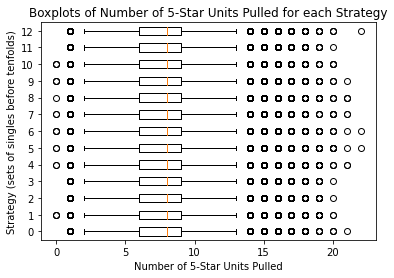

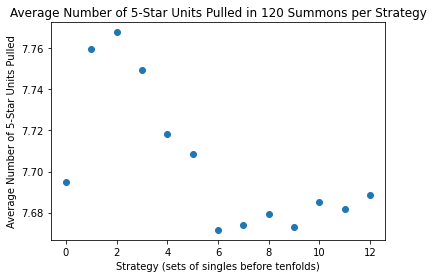

Strategy 0 resulted in an average of	7.6948800000	5-star units in 120 summons.
Strategy 1 resulted in an average of	7.7595800000	5-star units in 120 summons.
Strategy 2 resulted in an average of	7.7677900000	5-star units in 120 summons.
Strategy 3 resulted in an average of	7.7495600000	5-star units in 120 summons.
Strategy 4 resulted in an average of	7.7182500000	5-star units in 120 summons.
Strategy 5 resulted in an average of	7.7085900000	5-star units in 120 summons.
Strategy 6 resulted in an average of	7.6715800000	5-star units in 120 summons.
Strategy 7 resulted in an average of	7.6740800000	5-star units in 120 summons.
Strategy 8 resulted in an average of	7.6794300000	5-star units in 120 summons.
Strategy 9 resulted in an average of	7.6730800000	5-star units in 120 summons.
Strategy 10 resulted in an average of	7.6851600000	5-star units in 120 summons.
Strategy 11 resulted in an average of	7.6817800000	5-star units in 120 summons.
Strategy 12 resulted in an average of	7.6885800000

In [5]:
import statistics
import matplotlib.pyplot as plt
from scipy import stats

# Gets averages for each strategy
averagePerStrategy = [statistics.mean(strategyTrials) for strategyTrials in results]

# Boxplots for each strategy
plt.figure()
plt.boxplot(results, labels=strategies, vert=False)
plt.title("Boxplots of Number of 5-Star Units Pulled for each Strategy")
plt.xlabel("Number of 5-Star Units Pulled")
plt.ylabel("Strategy (sets of singles before tenfolds)")
plt.show()

# Scatter plot of means
plt.figure()
plt.plot(strategies, averagePerStrategy, 'o')
plt.title("Average Number of 5-Star Units Pulled in {} Summons per Strategy".format(numberSummons))
plt.xlabel("Strategy (sets of singles before tenfolds)")
plt.ylabel("Average Number of 5-Star Units Pulled")
plt.show()

# Print averages
for strategy, average in enumerate(averagePerStrategy):
    print("Strategy {} resulted in an average of\t{:10.10f}\t5-star units in {} summons.".format(strategy, average, numberSummons))
print("\n")
    
# ANOVA of strategies
_, pValueOfANOVANull = stats.f_oneway(*results)
print("The probability that the strategies have the same mean number of 5-star units pulled is {:10.10f} (calculated with ANOVA).\n".format(pValueOfANOVANull))

# t-Tests between strategies 1, 2, and 3 because they are often close to each other
_, pValueOfTTestNull0 = stats.ttest_ind(results[1], results[2])
_, pValueOfTTestNull1 = stats.ttest_ind(results[2], results[3])
print("The probability that differences between strategy 1 and strategy 2 were caused by chance is {:10.10f} (calculated with t-Test).".format(pValueOfTTestNull0))
print("The probability that differences between strategy 2 and strategy 3 were caused by chance is {:10.10f} (calculated with t-Test).\n".format(pValueOfTTestNull1))

# Prints the best strategy
print("Strategy {} performed the best!".format(averagePerStrategy.index(max(averagePerStrategy))))

## Discussion of Simulation
After running the simulations a couple of times, it seems like strategy 1 is the most consistent in performing the best. A couple of times strategy 2 pulled out ahead and there was one time when strategy 3 performed best.<br/><br/>
Based on the boxplots, it seems like the strategy used doesn't really affect the number of 5-star units pulled. Even though the scatter plot would seem to indicate a much starker difference between summoning strategies, it is important to keep in mind that the scale of the y-axis of the scatter plot is miniscule. However, by looking at the scatter plot and the raw averages, it seems like over tens of thousands of summons, the strategy chosen does end up affecting the fate of a few summons.<br/><br/>

## Exact Expected Value Calculations
Because the formula is recursive and monstorous, I initially thought I would be unable to use it to calculate anything within a reasonable time. When coding $E$ in a naive way, it did indeed take forever to run (I left the code running overnight and it made no progress).<br/>
However, once I realized that $E$ is a pure function, I realized that I could cache the results (this is called [memoization](https://en.wikipedia.org/wiki/Memoization)). $E$ being a pure function means that $E(a, b, c, d) = E(e, f, g, h)$ as long as $a = e$, $b = f$, $c = g$, and $d = h$; this condition sounds simple, but it means that I only need to calculate $E(a, b, c, d)$ once and every other time that I call $E(a, b, c, d)$, I can use the already calculated value and not need to recalculate it. After using caching, this code runs nearly instantaneously.<br/>
The nice aspect of this formula is that it is exact, barring computer limitations and/or mistakes on my part. Simulations are subject to RNG, but this formula will return the same results every time and is an exact model.

In [6]:
import math

lookupTable = {}

"""
Expected Value Formula as described in the Expected Value Formula section
"""
def E(n, r, s, l):
    # Use lookupTable if possible
    if (n, r, s, l) in lookupTable:
        return lookupTable[(n, r, s, l)]
    
    # Base Cases
    if n == 0:
        return 0
    if n == 1:
        return r
    
    failureProbability = 1 - r
    
    # Single Summon
    if l < 10 * s or n < 10:
        newRateOnNoFiveStar = r
        if (l + 1) % 10 == 0:
            newRateOnNoFiveStar += q
        expectedValue = r * (1 + E(n - 1, p, s, 0)) + failureProbability * E(n - 1, newRateOnNoFiveStar, s, l + 1)
    
    # Tenfold Summon
    else:
        expectedValueAfterSuccess = E(n - 10, p, s, 0)
        expectedValue = (failureProbability ** 10) * E(n - 10, r + q, s, l) + sum(math.comb(10, i) * (r ** i) * (failureProbability ** (10 - i)) * (i + expectedValueAfterSuccess) for i in range(1, 11))
    
    # Cache value in lookupTable and then return it
    lookupTable[(n, r, s, l)] = expectedValue
    return expectedValue

# Calculate expected values for each strategy
expectedValues = [E(numberSummons, p, strategy, 0) for strategy in strategies]

## Expected Value Results
Graphs and other raw results of the expected value results are below.

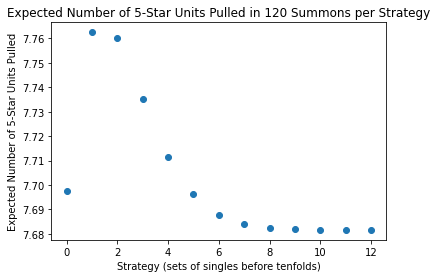

The expected value of strategy 0 is	7.6976542400	 5-star units over 120 pulls.
The expected value of strategy 1 is	7.7625140347	 5-star units over 120 pulls.
The expected value of strategy 2 is	7.7602842850	 5-star units over 120 pulls.
The expected value of strategy 3 is	7.7351917667	 5-star units over 120 pulls.
The expected value of strategy 4 is	7.7115442974	 5-star units over 120 pulls.
The expected value of strategy 5 is	7.6961060988	 5-star units over 120 pulls.
The expected value of strategy 6 is	7.6878256384	 5-star units over 120 pulls.
The expected value of strategy 7 is	7.6839875543	 5-star units over 120 pulls.
The expected value of strategy 8 is	7.6824125351	 5-star units over 120 pulls.
The expected value of strategy 9 is	7.6818373831	 5-star units over 120 pulls.
The expected value of strategy 10 is	7.6816518431	 5-star units over 120 pulls.
The expected value of strategy 11 is	7.6816000383	 5-star units over 120 pulls.
The expected value of strategy 12 is	7.6815880997	

In [7]:
plt.figure()
plt.plot(strategies, expectedValues, 'o')
plt.title("Expected Number of 5-Star Units Pulled in {} Summons per Strategy".format(numberSummons))
plt.xlabel("Strategy (sets of singles before tenfolds)")
plt.ylabel("Expected Number of 5-Star Units Pulled")
plt.show()

# Print data
for strategy in strategies:
    print("The expected value of strategy {} is\t{:10.10f}\t 5-star units over {} pulls.".format(strategy, expectedValues[strategy], numberSummons))
print("\n")

# Print best strategy
print("Strategy {} has the highest expected value in {} pulls!".format(expectedValues.index(max(expectedValues)), numberSummons))

## Calculator
After messing around with the above code, I came to the realization that the number of allowed summons does affect which strategy is the optimal strategy. For example, strategy 1 is best for 120 summons, but strategy 2 actually overcomes strategy 1 when allowing 240 summons. For this reason, I created some basic calculator code below (it requires the results of previous cells) to get the best strategy.<br/>
To run the calculator, change the numberSummons and p variables defined below to your liking and then re-run all cells (Kernel -> Restart & Run All). This will take a few seconds because of the simulation.<br/>
Eventually, I will make an easier-to-use web page to run the calculations to find the best strategy.

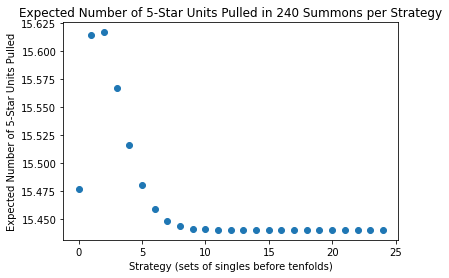

The expected value of strategy 0 is	15.4766740318	 5-star units over 240 pulls.
The expected value of strategy 1 is	15.6145945750	 5-star units over 240 pulls.
The expected value of strategy 2 is	15.6167885475	 5-star units over 240 pulls.
The expected value of strategy 3 is	15.5674540403	 5-star units over 240 pulls.
The expected value of strategy 4 is	15.5164398560	 5-star units over 240 pulls.
The expected value of strategy 5 is	15.4804381725	 5-star units over 240 pulls.
The expected value of strategy 6 is	15.4594856208	 5-star units over 240 pulls.
The expected value of strategy 7 is	15.4487900202	 5-star units over 240 pulls.
The expected value of strategy 8 is	15.4438680637	 5-star units over 240 pulls.
The expected value of strategy 9 is	15.4417974354	 5-star units over 240 pulls.
The expected value of strategy 10 is	15.4409949402	 5-star units over 240 pulls.
The expected value of strategy 11 is	15.4407071385	 5-star units over 240 pulls.
The expected value of strategy 12 is	1

In [8]:
numberSummons = 240 # Change me to whatever you want for this calculator
p = 0.06 # Change me to whatever you want for this calculator (gala summon rate is 0.06 and base summon rate is 0.04)

# Below code is for the calculator; do not change unless you know what you are doing

# Calculate all expected values
strategies = range(int(numberSummons / 10) + 1)
expectedValues = [E(numberSummons, p, strategy, 0) for strategy in strategies]

# Plot data
plt.figure()
plt.plot(strategies, expectedValues, 'o')
plt.title("Expected Number of 5-Star Units Pulled in {} Summons per Strategy".format(numberSummons))
plt.xlabel("Strategy (sets of singles before tenfolds)")
plt.ylabel("Expected Number of 5-Star Units Pulled")
plt.show()

# Print data
for strategy in strategies:
    print("The expected value of strategy {} is\t{:10.10f}\t 5-star units over {} pulls.".format(strategy, expectedValues[strategy], numberSummons))
print("\n")

# Print best strategy
print("Strategy {} has the highest expected value in {} pulls!".format(expectedValues.index(max(expectedValues)), numberSummons))

## Conclusion
The simulation results pointed to strategy 1 probably being the best way to get 5-star units in 120 pulls, but the expected value calculation indisputably proves that strategy 1 is the way to go. However, it is important to keep in mind that using any strategy in practice will only really make a difference over tens of thousands of pulls. Most of these calculations are practically useless but a fun exercise regardless.<br/>
In short, if you are doing 120 summons, you should always do 10 single summons before then performing tenfold summons until getting a 5-star unit. Once you get a 5-star unit (even if you get one in your first 10 single summons), start again from the 10 single summons. If you are using a different number of summons, the above calculator code will return the new optimal strategy.